# Imports

In [1]:
from matplotlib import pyplot as plt
import numpy as np
from common.baseclasses import AWA
from common import numerics as num

from importlib import reload
from scipy.stats import binned_statistic

from mnOPSuite.PRISM.python import scandelay_FTIR_new as sd
reload(sd)

<module 'mnOPSuite.PRISM.python.scandelay_FTIR_new' from '/Users/alexandersmcleod/tools/python/mnOPSuite/PRISM/python/scandelay_FTIR_new.py'>

# Simulate single-pixel spectroscopy

## Make simulated single-pixel data

In [2]:
times = 2*np.sin( np.linspace(-np.pi/2,np.pi/2,10000) ) # Sinusoidal times, from min to max and back
times = np.append(times,times[::-1]) # forward and backward
xs = 2*times*1e-12*3e10 # cm (we actual travel twice the reported time delay)

### Simulator for single channel intfg acquisition

Text(0, 0.5, 'Amplitude (V)')

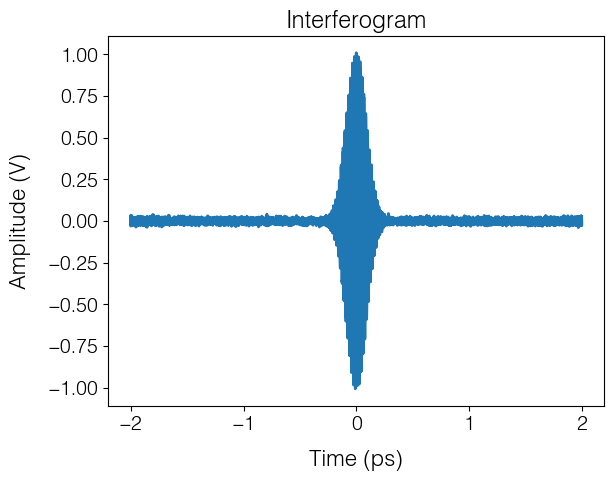

In [3]:
def gen_intfg(f0=1000,df=30,noise_lev=.01,amp=1,spectral_func = None):
    # f0 and df, sampling center frequency and sampling frequency width, in cm-1

    delf = 1/np.ptp(xs)
    fmax = 1/(2*np.max(np.diff(xs)))
    #print(fmax)
    freqs = np.arange(-fmax,fmax,delf)
    #print(freqs.shape)

    if spectral_func is None: svals = np.ones(freqs.shape)
    else: svals = spectral_func(freqs)

    #global s
    s = AWA(svals,axes=[freqs],axis_names=['X Frequency'])
    s = num.Spectrum(s,axis=0)
    s *= amp
    s *= np.exp(-(np.abs(freqs)-f0)**2/(2*df**2)) # Gaussian sampling envelope
    
    intfg = s.get_inverse(axis=0,x0=xs.min()).real
    intfg = intfg.interpolate_axis(xs,axis=0,bounds_error=False,extrapolate=True)
    noise = noise_lev*np.random.randn(len(xs))

    return intfg + noise

intfg = gen_intfg(amp = 1/150)

plt.plot(times,intfg)
plt.title('Interferogram')
plt.xlabel('Time (ps)')
plt.ylabel('Amplitude (V)')

### Stack simulated channels

We want a data shape `(Ncycles,1+Nchannels,Nxs)`

In [4]:
def gen_intfg_acqusitions(Ncycles=10,Nchannels=3,chan_amps = 1/150*np.array([1,.2,.05]),
                          noise_lev=.01,roll_px=10,time_noise=.1,
                         f0=1000,df=30,spectral_func=None):

    intfg_acquisitions = []

    intfgs_acquired = []
    for cyc in range(Ncycles):
        n = time_noise*np.random.randn(len(times))
        cyc_times = times + n
        channels = [cyc_times]
        for chan in range(Nchannels):
            intfg = gen_intfg(f0=f0,df=df,
                                amp=chan_amps[chan],noise_lev = noise_lev,
                             spectral_func=spectral_func)
            intfg = np.roll(intfg,roll_px,axis=0)
            channels.append(intfg)
        intfgs_acquired.append(channels)
    intfgs_acquired = np.array(intfgs_acquired)

    return intfgs_acquired

(10, 4, 20000)


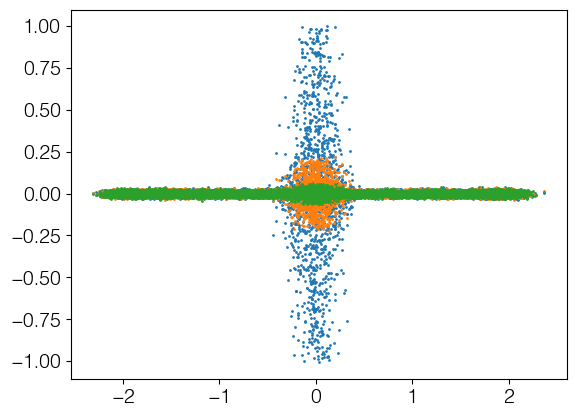

In [11]:
roll_px=10
chan_amps = 1/150*np.array([1,.2,.05])
intfg_acquisitions = gen_intfg_acqusitions(Ncycles=10,Nchannels=3,chan_amps = chan_amps,
                                              noise_lev=.01,roll_px=roll_px,time_noise=.1,
                                             f0=1000,df=30)

print(intfg_acquisitions.shape)

time_col = 0
cyc = -1
Nchannels = intfg_acquisitions.shape[1]-1
for chan in range(Nchannels):
    plt.plot(intfg_acquisitions[cyc,time_col],
             intfg_acquisitions[cyc,time_col+chan+1],
             ls='',marker='o',ms=1)
#plt.plot(intfgs_arr[cyc,time_col])
#plt.plot(cyc_times)

## Process single-pixel channel intfgs

We build data with a shift: 10
Fitted sinusoid parameters for X coordinate:
Harmonic 1: amp=-2, phase=0.00
Re-using pre-existing x-axis for interferograms...
Interferograms center (avg fwd/bwd) x0: 0.0006716679855247436
Fwd/bwd dx separation: -0.011345570578407868
Initially optimal shift: 9
Finally optimal shift: 9


(-0.5, 0.5)

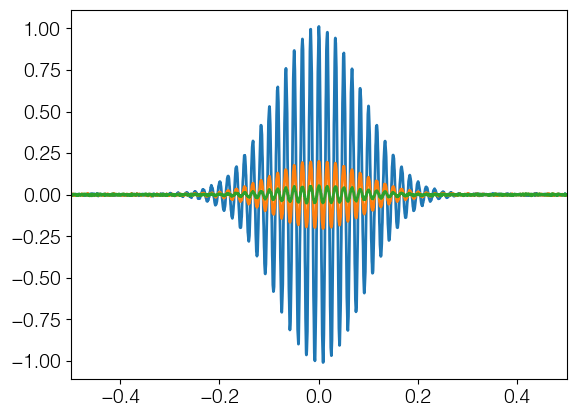

In [12]:
reload(sd)
print('We build data with a shift:',roll_px)
intfgs_data = sd.align_interferograms_new(intfg_acquisitions, delay_calibration_factor=1,
                                         shift0=0,optimize_shift=True,shift_range=5,
                                         flattening_order=1,noise=0)
times_avg = intfgs_data[0]
channels_avg = intfgs_data[1:]

for y in channels_avg:
    plt.plot(times_avg,y)
plt.xlim(-.5,.5)

## Process single-pixel channel spectra

(9, 720)


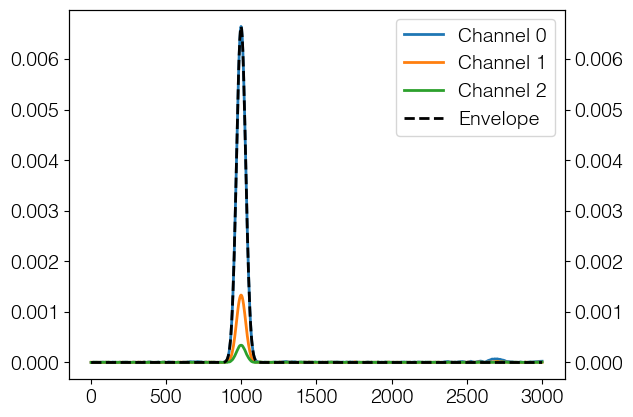

In [13]:
reload(sd)
spectra = sd.fourier_xform_new(intfgs_data,tsubtract=0,envelope=True,gain=1,fmin=0,fmax=sd.fmax,window=True,convert_to_wn=True)

# Should be shaped as:
# [freqs,
#  chan1_amp,
#  chan1_phase,
#  chan2_amp,
#  chan2_phase,
#  ... etc ...]
print(spectra.shape)

Nrows_env = sd.SpectralProcessor_new.Nrows_env

fs = spectra[0]
ls = []
for chan in range(Nchannels):
    s_abs_row = 1+Nrows_env+2*chan
    l, = plt.plot(fs,spectra[1+Nrows_env+2*chan],label='Channel %i'%chan)
    ls.append(l)
#plt.gca().set_yscale('log')
    
plt.twinx()
env_row = 1
l,=plt.plot(fs,spectra[1],ls='--',color='k',label='Envelope')
ls.append(l)
plt.legend(handles=ls)
#plt.gca().set_yscale('log')

## Build single-pixel sample and reference accumulations

In [14]:
roll_px=10
shift0 = roll_px
optimize_shift=True
shift_range = 5 # Don't let this get bigger than a wavelength

noise_lev = 1e-2
time_noise = 1e-2

df=30
f0s = np.arange(600,1500,50)

reload(sd)

<module 'mnOPSuite.PRISM.python.scandelay_FTIR_new' from '/Users/alexandersmcleod/tools/python/mnOPSuite/PRISM/python/scandelay_FTIR_new.py'>

### Sample

In [15]:
fsamp = 1000
g=50
spectral_func_samp = lambda f: 1+0.5*fsamp*g/(fsamp**2-f**2-1j*f*g)
spectral_func = spectral_func_samp

Generating accumulation 1 of 18...
Fitted sinusoid parameters for X coordinate:
Harmonic 1: amp=-2, phase=0.00
Re-using pre-existing x-axis for interferograms...
Finally optimal shift: 10
Generating accumulation 2 of 18...
Fitted sinusoid parameters for X coordinate:
Harmonic 1: amp=-2, phase=0.00
Finally optimal shift: 10
Generating accumulation 3 of 18...
Fitted sinusoid parameters for X coordinate:
Harmonic 1: amp=-2, phase=0.00
Finally optimal shift: 10
Generating accumulation 4 of 18...
Fitted sinusoid parameters for X coordinate:
Harmonic 1: amp=-2, phase=0.00
Finally optimal shift: 10
Generating accumulation 5 of 18...
Fitted sinusoid parameters for X coordinate:
Harmonic 1: amp=-2, phase=0.00
Finally optimal shift: 10
Generating accumulation 6 of 18...
Fitted sinusoid parameters for X coordinate:
Harmonic 1: amp=-2, phase=0.00
Finally optimal shift: 10
Generating accumulation 7 of 18...
Fitted sinusoid parameters for X coordinate:
Harmonic 1: amp=-2, phase=0.00
Finally optimal 

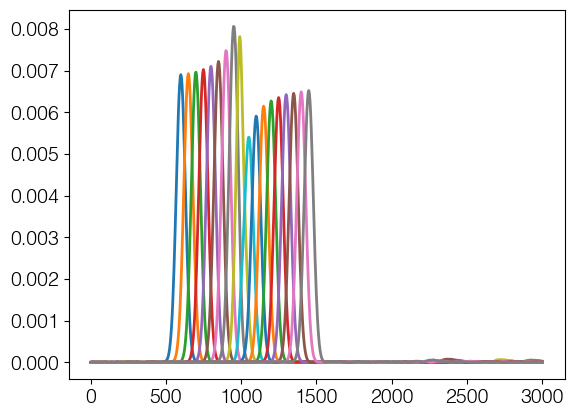

In [16]:
chan_amps = 1/150 * np.array([1,.2,.05])

spectra_accumulated = []
for i,f0 in enumerate(f0s):
    print('Generating accumulation %i of %i...'%(i+1,len(f0s)))
    intfg_acquisitions = gen_intfg_acqusitions(Ncycles=10,Nchannels=3,chan_amps = chan_amps,
                                                  noise_lev=noise_lev,roll_px=roll_px,time_noise=time_noise,
                                                 f0=f0,df=df,
                                               spectral_func=spectral_func)
    intfgs_data = sd.align_interferograms_new(intfg_acquisitions, delay_calibration_factor=1,
                                             shift0=shift0,optimize_shift=optimize_shift,shift_range=shift_range,
                                             flattening_order=1,noise=0)
    spectra = sd.fourier_xform_new(intfgs_data,tsubtract=0,
                                   envelope=True,gain=1,
                                   fmin=0,fmax=sd.fmax,window=True,convert_to_wn=True)

    fs = spectra[0]
    plot_chan = 0
    plt.plot(fs,spectra[1+Nrows_env+2*plot_chan])

    spectra_accumulated.append(spectra)

In [17]:
sample_spectra = np.array(spectra_accumulated)

### Reference

In [18]:
spectral_func_ref = lambda f: np.ones(f.shape)
spectral_func = spectral_func_ref

In [19]:
intfgs_data.shape

(4, 10000)

Generating accumulation 1 of 18...
Fitted sinusoid parameters for X coordinate:
Harmonic 1: amp=-2, phase=0.00
Finally optimal shift: 10
Generating accumulation 2 of 18...
Fitted sinusoid parameters for X coordinate:
Harmonic 1: amp=-2, phase=0.00
Finally optimal shift: 10
Generating accumulation 3 of 18...
Fitted sinusoid parameters for X coordinate:
Harmonic 1: amp=-2, phase=0.00
Finally optimal shift: 10
Generating accumulation 4 of 18...
Fitted sinusoid parameters for X coordinate:
Harmonic 1: amp=-2, phase=0.00
Finally optimal shift: 10
Generating accumulation 5 of 18...
Fitted sinusoid parameters for X coordinate:
Harmonic 1: amp=-2, phase=6.28
Finally optimal shift: 10
Generating accumulation 6 of 18...
Fitted sinusoid parameters for X coordinate:
Harmonic 1: amp=-2, phase=0.00
Finally optimal shift: 10
Generating accumulation 7 of 18...
Fitted sinusoid parameters for X coordinate:
Harmonic 1: amp=-2, phase=0.00
Finally optimal shift: 10
Generating accumulation 8 of 18...
Fitted

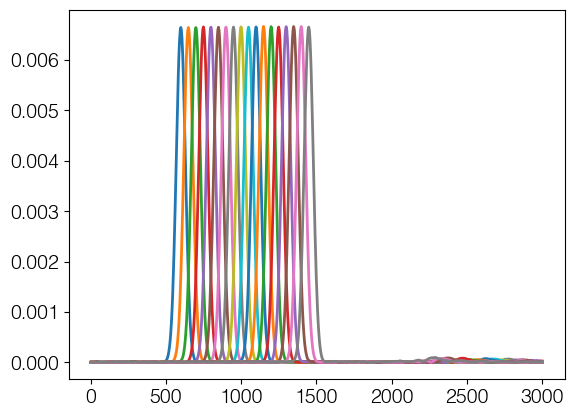

In [20]:
chan_amps = 1/150 * np.array([1,.2,.05])

spectra_accumulated = []
for i,f0 in enumerate(f0s):
    print('Generating accumulation %i of %i...'%(i+1,len(f0s)))
    intfg_acquisitions = gen_intfg_acqusitions(Ncycles=10,Nchannels=3,chan_amps = chan_amps,
                                                  noise_lev=noise_lev,roll_px=roll_px,time_noise=time_noise,
                                                 f0=f0,df=df,
                                               spectral_func=spectral_func)
    intfgs_data = sd.align_interferograms_new(intfg_acquisitions, delay_calibration_factor=1,
                                             shift0=shift0,optimize_shift=optimize_shift,shift_range=shift_range,
                                             flattening_order=1,noise=0)
    spectra = sd.fourier_xform_new(intfgs_data,tsubtract=0,
                                   envelope=True,gain=1,
                                   fmin=0,fmax=sd.fmax,window=True,convert_to_wn=True)

    fs = spectra[0]
    plot_chan = 0
    plt.plot(fs,spectra[1+Nrows_env+2*plot_chan])

    spectra_accumulated.append(spectra)

In [21]:
ref_spectra = np.array(spectra_accumulated)

### Normalize with Spectral Processor

In [22]:
ref_spectra = np.array(ref_spectra)
sample_spectra = np.array(sample_spectra)

Processing reference spectra...
Aligning and enveloping spectra...
Processing sample spectra...
Aligning and enveloping spectra...


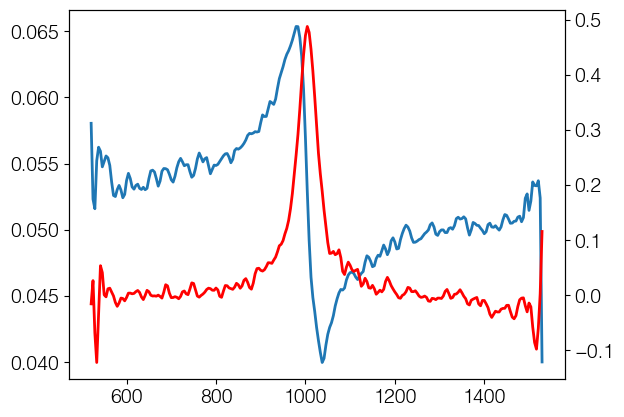

In [23]:
# Restrict brightbeam to `Nchan_BB` channels
Nchan_BB=1
sample_BB_spectra = ref_BB_spectra = ref_spectra[:,:1+Nrows_env+2*Nchan_BB]

reload(sd)
SP = sd.SpectralProcessor_new(sample_spectra,
                             sample_BB_spectra,
                             ref_spectra,
                             ref_BB_spectra,
                             phase_alignment_exponent=2)
f,snorm_abs,snorm = SP(channel=3, channel_ref=1, channel_BB=1,
                         optimize_BB=False,
                         align_phase=False,
                         apply_envelope=True,
                         envelope_width=2,
                         valid_thresh=.01,
                         smoothing=None,window=None,
                         view_phase_alignment=False,
                         view_phase_alignment_leveling=6,
                         BB_normalize=True,BB_phase=False,
                         recompute_reference=True)

plt.plot(f,snorm_abs)
plt.twinx()
plt.plot(f,np.angle(snorm),color='r')

We need the following labview-level changes:
* Input to `align_interferograms`:
    * Make incoming `intfgs_arr` to be size `(Ncycles,1+Nchannels,Nxs)`
    * Make sure time/x-axis is first channel
* Output from `align_interferograms` will be size `(1+Nchannels,Nxs)`
* Input to `fourier_xform_new` will be same, size `(1+Nchannels,Nxs)`
* Output from `fourier_xform_new` will be size `(1+Nrows_env+2*Nchannels, Nfreqs)=(3+2*Nchannels, Nfreqs)`
* Each accumulated multi-channel spectra will be same, size `(3+2*Nchannels, Nfreqs)`
* Larger holder for BB or sample will be size `(Naccumulations, 3+2*Nchannels, Nfreqs)`